In [18]:
import numpy as np
import pandas as pd
from pandas import HDFStore,DataFrame
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
import pyarrow.parquet as pq
import pyarrow as pa
from pyspark import SparkFiles
import plotly
import  plotly.plotly as py
import plotly.graph_objs as go
import matplotlib.pyplot as plt

plotly.tools.set_credentials_file(username='atlascli', api_key='wUzqyRtxdsxbyAaPgviy')

In [ ]:
spark = SparkSession \
    .builder \
    .appName("Python Spark SQL basic example") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

In [57]:
#inputfile="fntoutput-disconnected.parquet"
#outputfilemerged="fntdisc_merged_coolrcached.parquet"

#inputfile="fntoutput-cached.parquet"
#outputfilemerged="fntcached_merged_coolrcached.parquet"

#inputfile="fntoutput.parquet"
#outputfilemerged="fnt_merged_coolrcached.parquet"

inputfile="allfnt-timerange-cached.parquet"
outputfilemerged="allfnt-timerange-cached_merged_coolrcached.parquet"

inputfile="allfnt-timerange-notcached.parquet"
outputfilemerged="allfnt-timerange-notcached_merged_coolrcached.parquet"





In [58]:
def getRunLumiSinceUntil(isince,iuntil):
    Run_Since = isince >> 32
    LBN_Since = isince & 0xFFFFFFFF
    Run_Until = iuntil >> 32
    LBN_Until = iuntil & 0xFFFFFFFF
    return (Run_Since, LBN_Since, Run_Until, LBN_Until)
#print ("Run/LB Since is %d / %d" % (Run_Since, LBN_Since))
#print ("Run/LB Until is %d / %d" % (Run_Until, LBN_Until))



In [59]:
def getRun(itime):
    Run_t = itime >> 32
    return Run_t

def getLumi(itime):
    LBN_t = itime & 0xFFFFFFFF
    return LBN_t

def getTime(itime):
    time_sec = itime / 1000000000


In [60]:
def getTimeSinceUntil(isince,iuntil):
    import datetime

    #-- must divide by 10^9 to convert from nanoseconds to seconds
    IOV_SINCE_sec = isince / 1000000000
    IOV_UNTIL_sec = iuntil / 1000000000

    #-- this python returns the date and time in a formatted string
    IOV_SINCE_sec_date = datetime.datetime.utcfromtimestamp(IOV_SINCE_sec).strftime('%Y-%m-%dT%H:%M:%S')
    IOV_UNTIL_sec_date = datetime.datetime.utcfromtimestamp(IOV_UNTIL_sec).strftime('%Y-%m-%dT%H:%M:%S')
    return (IOV_SINCE_sec, IOV_UNTIL_sec)

In [61]:
def createSparkDfMerged(inputfile, outputfile):
    spark_fnt = spark.read.parquet(inputfile) # read disconn queries
    spark_coolr_cached = spark.read.parquet("parse_sql_allfnt.parquet") # read cached queries
    spark_fnt.createOrReplaceTempView("Frontier")
    spark_coolr_cached.createOrReplaceTempView("CoolrCached")  
    # Count entries
    countsql = spark.sql("SELECT count(*) as allfnt_entries FROM Frontier")
    countsql.show()
    countsql = spark.sql("SELECT count(*) as coolr_entries FROM CoolrCached")
    countsql.show()
    # Merge DF
    merged_sql = spark.sql("SELECT f.time,f.disconn,f.frontierserver,f.dbtime,f.initthreads,f.cached,f.db,f.schema,f.node_id,f.tag_id,f.pandaid,f.procerror,f.queryiov,f.querytime,f.fsize,f.rejected,f.since,f.until,f.run_since,f.lb_since,f.run_until,f.lb_until,f.time_since,f.time_until, c.node as nodefullpath,c.nodetime as nodetype,c.tag as tagname FROM Frontier as f inner join CoolrCached as c WHERE f.schema=c.schema and f.db=c.db and f.node_id=c.node_id and f.tag_id=c.tag_id")
    outdir="/workspace/AnalyticsNotebooks/Formica/parquet"
    merged_sql.write.parquet(outdir+"/"+outputfile)
    return merged_sql
    ### This creates a panda dataframe
#    pdf = merged_sql.toPandas()
#    pdf
#    table = pa.Table.from_pandas(pdf)
#    pq.write_table(table, outputfile)



In [62]:
spark_merged_df = createSparkDfMerged(inputfile,outputfilemerged)
spark_merged_df.show(10)
spark_merged_df.createOrReplaceTempView("FrontierCoolr")

+--------------+
|allfnt_entries|
+--------------+
|       1196048|
+--------------+

+-------------+
|coolr_entries|
+-------------+
|          660|
+-------------+

+--------------------+-------+--------------------+------+-----------+------+-------+--------------------+-------+------+----------+---------+------------+---------+------+--------+-------------------+-------------------+---------+----------+---------+----------+----------+----------+--------------------+--------+--------------------+
|                time|disconn|      frontierserver|dbtime|initthreads|cached|     db|              schema|node_id|tag_id|   pandaid|procerror|    queryiov|querytime| fsize|rejected|              since|              until|run_since|  lb_since|run_until|  lb_until|time_since|time_until|        nodefullpath|nodetype|             tagname|
+--------------------+-------+--------------------+------+-----------+------+-------+--------------------+-------+------+----------+---------+------------+----

In [63]:
countsql = spark.sql("SELECT count(*) as coolr_entries FROM FrontierCoolr")
countsql.show()



+-------------+
|coolr_entries|
+-------------+
|      1176640|
+-------------+



In [87]:
def createPandaDfTimeBins(spark_newdf,condition=''):
    spark_newdf.printSchema()
    spark_newdf.createOrReplaceTempView("FrontierCoolr")
    from pyspark.sql.functions import to_timestamp, unix_timestamp,from_unixtime

    spdf = spark.sql("SELECT to_timestamp(time) as stamp, from_unixtime(int(unix_timestamp(to_timestamp(time))/300)*300) as unixtime, querytime, initthreads, dbtime, fsize, schema, db, nodefullpath, nodetype, run_since, run_until, lb_since, lb_until, time_since, time_until, CASE WHEN nodetype = 'time' THEN (time_until-time_since) ELSE (run_until-run_since) END iovdiff FROM FrontierCoolr "+condition)
    spdf.show(10)
    spdf.createOrReplaceTempView("FrontierTime")
    df_schemas = spark.sql("SELECT distinct schema FROM FrontierTime")
    print('Dataframe schema is reduced for the plots....be careful; eventually you should add column in the query above...')
    print(df_schemas.schema.names)
    schema_list=[x['schema'] for x in df_schemas.rdd.collect()]
    print('Looping over the schema list...')
    print(schema_list)
    spdf_list=[]
    for aschema in schema_list:
        rowdic={}
        query = "SELECT unixtime, count(unixtime) as nentries, max(initthreads) as maxthreads, avg(dbtime) as mdbt, avg(iovdiff) as miovdiff, avg(querytime) as mqtime, avg(fsize) as msize FROM FrontierTime WHERE schema='%s' GROUP BY unixtime ORDER BY unixtime asc" % (aschema)
        #print(query)
        rowdic[aschema] = spark.sql(query)
        spdf_list.append(rowdic)

    pandas_list=[]
    for dfdic in spdf_list:
        for key,mdf in dfdic.items():
            print('Creating pandas df from %s' % key)
            pandadic={}
            pandadic[key] = mdf.toPandas()
            pandas_list.append(pandadic)

    return pandas_list

In [65]:
def matplotPanda(pandadf,varx,vary):
    ## Example for matplotlib....uses panda
    fig, ax = plt.subplots()
#newdf.hist('querytime',ax=ax)
    #plt.scatter(newdf.querytime,newdf.fsize)
    if vary is not None:
        plt.scatter(pandadf[varx],pandadf[vary])
    else:
        pandadf.hist(varx,ax=ax)
        ax.set_yscale('log')




In [66]:
pdf = spark_merged_df.toPandas()

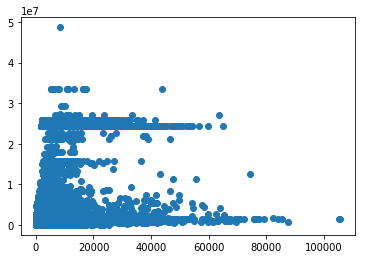

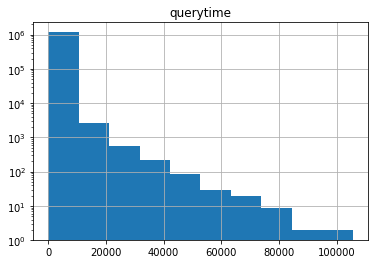

In [67]:
matplotPanda(pdf,'querytime','fsize')
matplotPanda(pdf,'querytime',None)

In [84]:
pandas_list = createPandaDfTimeBins(spark_merged_df," where querytime>=0 and (disconn='true' or rejected='true' or procerror='true')")

root
 |-- time: string (nullable = true)
 |-- disconn: string (nullable = true)
 |-- frontierserver: string (nullable = true)
 |-- dbtime: long (nullable = true)
 |-- initthreads: long (nullable = true)
 |-- cached: string (nullable = true)
 |-- db: string (nullable = true)
 |-- schema: string (nullable = true)
 |-- node_id: long (nullable = true)
 |-- tag_id: long (nullable = true)
 |-- pandaid: long (nullable = true)
 |-- procerror: string (nullable = true)
 |-- queryiov: long (nullable = true)
 |-- querytime: long (nullable = true)
 |-- fsize: long (nullable = true)
 |-- rejected: string (nullable = true)
 |-- since: string (nullable = true)
 |-- until: string (nullable = true)
 |-- run_since: long (nullable = true)
 |-- lb_since: long (nullable = true)
 |-- run_until: long (nullable = true)
 |-- lb_until: long (nullable = true)
 |-- time_since: long (nullable = true)
 |-- time_until: long (nullable = true)
 |-- nodefullpath: string (nullable = true)
 |-- nodetype: string (nullable 

In [88]:
pandas_list = createPandaDfTimeBins(spark_merged_df," where querytime>=0 and (disconn='false' and rejected='false' and procerror='false')")

root
 |-- time: string (nullable = true)
 |-- disconn: string (nullable = true)
 |-- frontierserver: string (nullable = true)
 |-- dbtime: long (nullable = true)
 |-- initthreads: long (nullable = true)
 |-- cached: string (nullable = true)
 |-- db: string (nullable = true)
 |-- schema: string (nullable = true)
 |-- node_id: long (nullable = true)
 |-- tag_id: long (nullable = true)
 |-- pandaid: long (nullable = true)
 |-- procerror: string (nullable = true)
 |-- queryiov: long (nullable = true)
 |-- querytime: long (nullable = true)
 |-- fsize: long (nullable = true)
 |-- rejected: string (nullable = true)
 |-- since: string (nullable = true)
 |-- until: string (nullable = true)
 |-- run_since: long (nullable = true)
 |-- lb_since: long (nullable = true)
 |-- run_until: long (nullable = true)
 |-- lb_until: long (nullable = true)
 |-- time_since: long (nullable = true)
 |-- time_until: long (nullable = true)
 |-- nodefullpath: string (nullable = true)
 |-- nodetype: string (nullable 

In [69]:
def plotJsBySchema(pandas_list,xv,yv,amode='lines',fname='output-plotly'):
    data = []
    for pdfdic in pandas_list:
        for key,mdf in pdfdic.items():
            #print('Creating Scatter from %s' % key)
            if amode is None:
                amode='lines'
            gobj = go.Scatter(name=key, x=mdf[xv], y=mdf[yv], mode=amode)
            data.append(gobj)

    return py.iplot(data, filename=fname)    

In [89]:
plotJsBySchema(pandas_list,'unixtime','nentries','lines','pjs-nentries-vs-time')

In [90]:
plotJsBySchema(pandas_list,'unixtime','mqtime','lines','pjs-mqtime-vs-time')

In [91]:
plotJsBySchema(pandas_list,'unixtime','maxthreads','lines','pjs-maxthreads-vs-time')

In [92]:
plotJsBySchema(pandas_list,'unixtime','mdbt','lines','pjs-mdbt-vs-time')

In [93]:
plotJsBySchema(pandas_list,'unixtime','msize','lines','pjs-msize-vs-time')

In [94]:
plotJsBySchema(pandas_list,'msize','mqtime','markers','pjs-msize-vs-mqtime')

In [ ]:
#from pyspark_dist_explore import hist
#import matplotlib.pyplot as plt

chk3_sql = spark.sql("SELECT schema, avg(querytime) as meanqryt FROM FrontierCoolr WHERE querytime>1 and db='CONDBR2' GROUP BY schema")
chk3_sql.show(100)

chk4_sql = spark.sql("SELECT schema, db, count(schema,db) as nentries, avg(querytime) as meanqryt FROM FrontierCoolr WHERE querytime>1 GROUP BY schema,db")
chk4_sql.show(100)

chk5_sql = spark.sql("SELECT count(schema) FROM Frontier WHERE schema='none' ")
chk5_sql.show(10)

#fig, ax = plt.subplots()
#hist(ax, chk_sql, bins = 20, color=['red'])

In [ ]:
chk6_sql = spark.sql("SELECT schema, nodefullpath, db, querytime, unixtime, time_since, time_until FROM FrontierTime WHERE querytime>=0 and iovdiff>5000 and db='CONDBR2' and schema='ATLAS_COOLOFL_MUONALIGN'")
chk6_sql.show(100,False)


In [ ]:
chk6_sql = spark.sql("SELECT schema, nodefullpath, db, querytime, unixtime, time_since, time_until FROM FrontierTime WHERE querytime>=1000 and db='CONDBR2' and schema='ATLAS_COOLONL_RPC'")
chk6_sql.show(100,False)



In [ ]:
chk_sql.createOrReplaceTempView("CoolrAnalytics")

In [ ]:
chk2_sql = spark.sql("SELECT sum(nentries) FROM CoolrAnalytics ")
chk2_sql.show(100)




In [ ]:
notgoodcoolr_sql = spark.sql("SELECT f.time,f.cached,f.db,f.schema,f.node_id,f.tag_id,f.pandaid,f.procerror,f.queryiov,f.querytime,f.rejected,f.since,f.until,c.node as nodefullpath,c.nodetime as nodetype,c.tag as tagname FROM Frontier as f right outer join CoolrCached as c WHERE f.schema=c.schema and f.db=c.db and f.node_id=c.node_id and f.tag_id=c.tag_id")
notgoodcoolr_sql.show(10)
notgoodcoolr_sql.createOrReplaceTempView("FrontierAnalytics")
notgoodcoolr_chk =  spark.sql("SELECT count(*) FROM FrontierAnalytics where cached = 'true'")
notgoodcoolr_chk.show(10)   
notgoodcoolr_chk =  spark.sql("SELECT max(time) as maxdate, min(time) as mindate FROM FrontierAnalytics")
notgoodcoolr_chk.show(10,False)                     

# Look at the data for ALL queries in the period. Select may be only cc frontier servers.
Checking data in allfnt-timerange file.

In [ ]:
spark_allfnt = spark.read.parquet('allfnt-timerange.parquet') # read disconn queries
spark_allfnt.show(10)
